# Running KRAKEN Ocean Acoustic Model

In [1]:
import numpy as np

from tritonoa.core import Top, Bottom, SoundSpeedProfile, Layer, Source, Receiver
from tritonoa.kraken import KRAKENModelConfiguration
from tritonoa.plotting import plot_TL_2d
from tritonoa.profiles import MunkSSP
from tritonoa.sp import normalize_pressure

## Munk Profile

Running KRAKENC


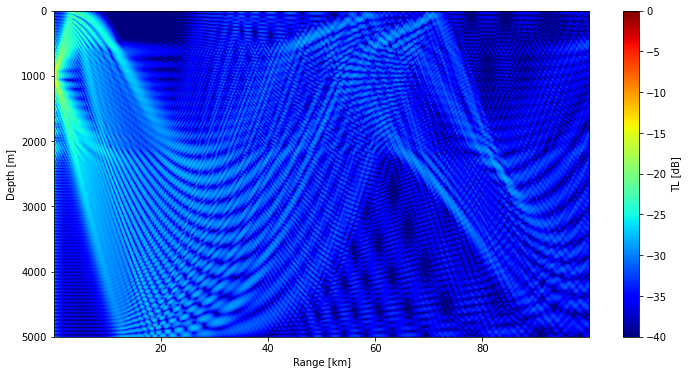

In [7]:
profile = "Munk"
title = profile

top = Top(opt="NVW")

ssp1 = MunkSSP(5000, dz=5)
layer1 = Layer(ssp1)
layers = [layer1]

bottom = Bottom(opt="A", z=layer1.z_max, c_p=1600, rho=1.8, a_p=0.8)

source = Source(1000)
receiver = Receiver(np.arange(0, layer1.z_max+1, 5), r_max=100, dr=10)

freq = 50
clow = 1500
chigh = 1600

exp_actual = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)

model = "KRAKENC"
exp_actual.run(fldflag=True, model=model)
p = normalize_pressure(exp_actual.modes.p, log=True)

fig = plot_TL_2d(
    p,
    exp_actual.receiver.z,
    exp_actual.receiver.r,
    # title=f"{model} | {profile} profile | {exp_actual.source.z} m | {freq} Hz",
    title="",
    figsize=(12, 6)
)
fig.savefig("smimage.jpg", dpi=300)

## SWELLEX

Running KRAKENC


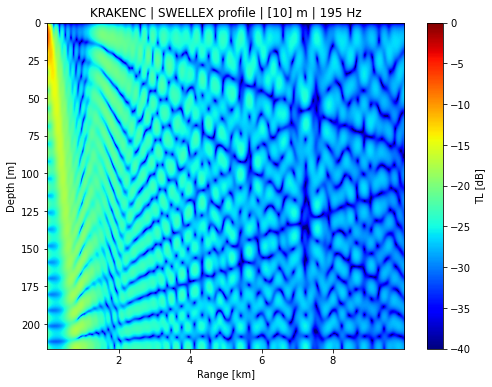

In [3]:
profile = "SWELLEX"
title = profile

top = Top()

ssp1 = SoundSpeedProfile(z=[0, 217], c_p=[1521.95, 1482], rho=1.)
ssp2 = SoundSpeedProfile(z=[217, 240], c_p=[1572.37, 1593.02], rho=1.8, a_p=0.3)
ssp3 = SoundSpeedProfile(z=[240, 1040], c_p=[1881, 3245.8], rho=2.1, a_p=0.09)
layer1 = Layer(ssp1)
layer2 = Layer(ssp2)
layer3 = Layer(ssp3)
layers = [layer1, layer2, layer3]

bottom = Bottom(opt="A", z=layer3.z_max+1, c_p=5200, rho=2.7, a_p=0.03)

source = Source(10)
receiver = Receiver(np.arange(0, layer1.z_max, 0.5), r_max=10, dr=0.5)

freq = 195
clow = 1500
chigh = 1600

exp_actual = KRAKENModelConfiguration(
    title,
    freq,
    layers,
    top,
    bottom,
    source,
    receiver,
    clow=clow,
    chigh=chigh,
    tmpdir="tmp"
)

model = "KRAKENC"
exp_actual.run(fldflag=True, model=model)
p = normalize_pressure(exp_actual.modes.p, log=True)

fig = plot_TL_2d(
    p,
    exp_actual.receiver.z,
    exp_actual.receiver.r,
    title=f"{model} | {profile} profile | {exp_actual.source.z} m | {freq} Hz"
)